# 1. Data Load

In [119]:
import pandas as pd

df = pd.read_csv('diamonds.csv', index_col=0)
df_copy = df.copy()
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


# 2. Feature Engineering

In [120]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

df.dropna(inplace=True)

cut_map = {'Ideal': 0, 'Premium': 1, 'Very Good': 2, 'Good': 3, 'Fair': 4}
color_map = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}
clarity_map = {'IF': 0, 'VVS1': 1, 'VVS2': 2, 'VS1': 3, 'VS2': 4, 'SI1': 5, 'SI2': 6, 'I1': 7}

df['cut'] = df['cut'].map(cut_map)
df['color'] = df['color'].map(color_map)
df['clarity'] = df['clarity'].map(clarity_map)

features_to_scale = ['carat', 'depth', 'table', 'x', 'y', 'z']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,-1.198168,0,1,6,-0.174092,-1.099672,326,-1.587837,-1.536196,-1.571129
2,-1.240361,1,1,5,-1.360738,1.585529,326,-1.641325,-1.658774,-1.741175
3,-1.198168,3,1,3,-3.385019,3.375663,327,-1.498691,-1.457395,-1.741175
4,-1.071587,1,5,4,0.454133,0.242928,334,-1.364971,-1.317305,-1.287720
5,-1.029394,3,6,6,1.082358,0.242928,335,-1.240167,-1.212238,-1.117674


# 3, Dimension Reduction

Correlation matrix


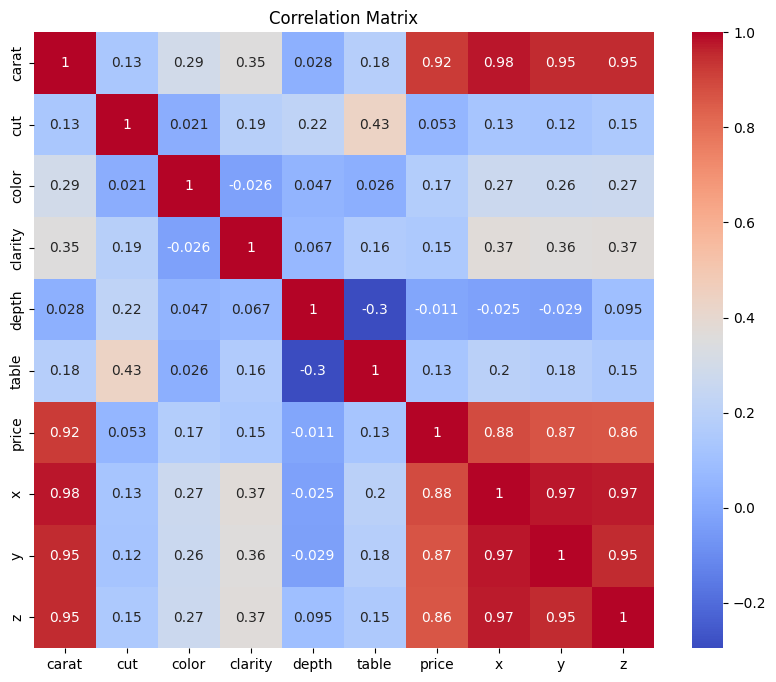

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Select 4 important features

In [122]:
from sklearn.ensemble import RandomForestRegressor

selected_features = ['carat', 'clarity', 'color', 'y']
X_selected = df[selected_features]
y_selected = df['price']

Random Forest

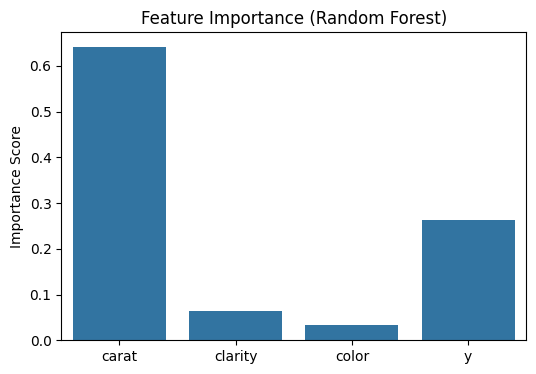

In [123]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_selected, y_selected)
importances = rf.feature_importances_

plt.figure(figsize=(6, 4))
sns.barplot(x=selected_features, y=importances)
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

PCA

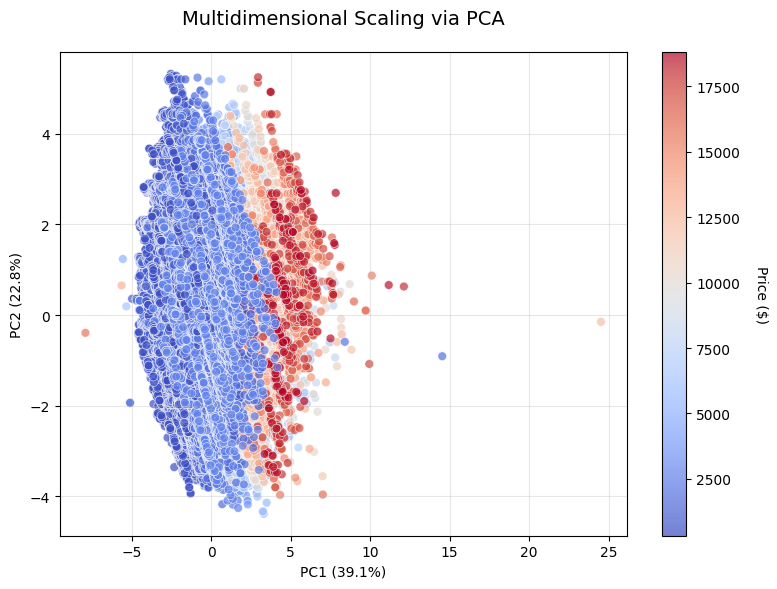

In [124]:
from sklearn.decomposition import PCA

X = df.drop(columns=['price'])
y = df['price']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
                     c=y, cmap='coolwarm',
                     s=40, alpha=0.7,
                     edgecolor='w', linewidth=0.5)

plt.colorbar(scatter).set_label('Price ($)', rotation=270, labelpad=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("Multidimensional Scaling via PCA", fontsize=14, pad=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Reduced Order Model

Single Variable Linear Regression

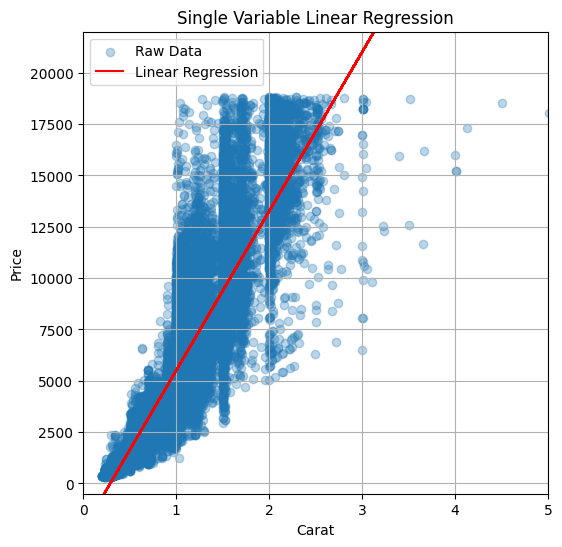

In [129]:
from sklearn.linear_model import LinearRegression

X = df_copy[['carat']]
y = df['price']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(X, y, alpha=0.3, label='Raw Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.xlim(0, 5)
plt.ylim(-500, 22000)
plt.title('Single Variable Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

Multiple Variable Linear Regression

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


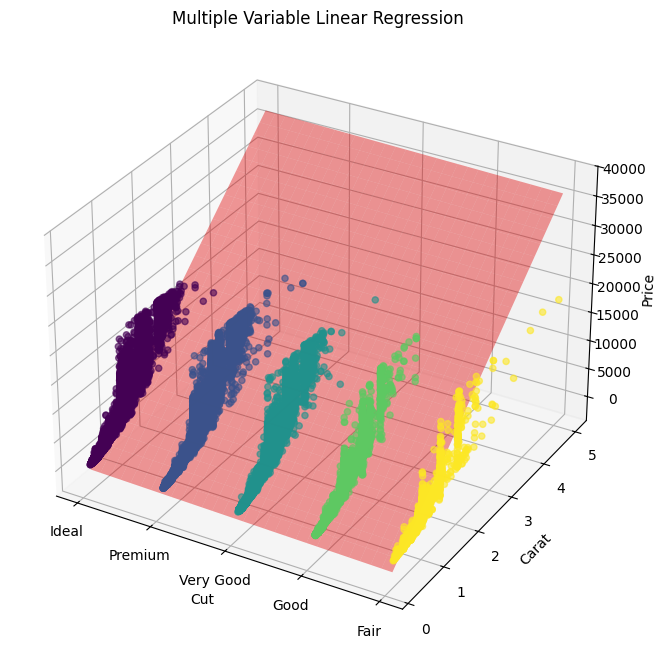

In [138]:
import numpy as np

X = pd.concat([df['cut'], df_copy['carat']], axis=1)
y = df['price']

model = LinearRegression()
model.fit(X, y)

cut_vals = np.linspace(X['cut'].min(), X['cut'].max(), 30)
carat_vals = np.linspace(X['carat'].min(), X['carat'].max(), 30)
cut_grid, carat_grid = np.meshgrid(cut_vals, carat_vals)
X_grid = np.c_[cut_grid.ravel(), carat_grid.ravel()]
price_grid = model.predict(X_grid).reshape(cut_grid.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X['cut'], X['carat'], y, c=X['cut'], cmap='viridis', alpha=0.6)
ax.plot_surface(cut_grid, carat_grid, price_grid, color='red', alpha=0.4)

ax.set_xlabel('Cut')
ax.set_ylabel('Carat')
ax.set_zlabel('Price')
plt.title('Multiple Variable Linear Regression')

cut_map = {'Ideal': 0, 'Premium': 1, 'Very Good': 2, 'Good': 3, 'Fair': 4}
cut_labels = list(cut_map.keys())
cut_ticks = list(cut_map.values())
ax.set_xticks(cut_ticks)
ax.set_xticklabels(cut_labels)

plt.show()

Multivariable Linear Regression

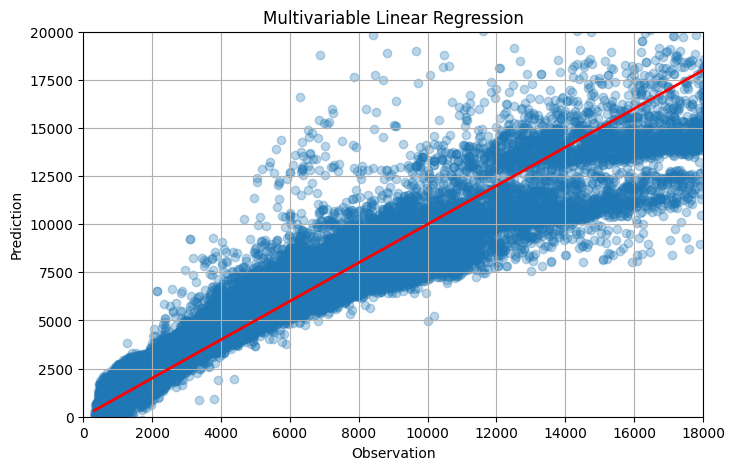

In [139]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']

X = df.drop(columns=['price'])
y = df['price']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', linewidth=2)
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Multivariable Linear Regression')
plt.xlim(0, 18000)
plt.ylim(0, 20000)
plt.grid(True)
plt.show()

Neural Network Architecture

In [140]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(9,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

y_pred = model.predict(X_test).flatten()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 25756486.0000
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5116051.5000
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3340420.5000
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2666668.7500
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2183818.7500
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1819695.8750
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1658059.5000
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1502995.1250
Epoch 9/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1397723.7500
Epoch 10/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1114047.1250
Epoch 11/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1187473.2500
Epoch 12/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 915176.9375
Epoch 13/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1019546.7500
Epoch 14/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - los

In [141]:
print("✅ Neural Network Evaluation")
print("Mean Absolute Error :", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error :", mean_squared_error(y_test, y_pred))
print("R-squared (R²)     :", r2_score(y_test, y_pred))

✅ Neural Network Evaluation
Mean Absolute Error : 435.46923828125
Mean Squared Error : 720625.5
R-squared (R²)     : 0.9546685814857483


# 5. System & Design

In [143]:
scaled = ['carat', 'depth', 'table', 'x', 'y', 'z']

num_samples = 4
X_test_sample = X_test[:num_samples].copy()
y_test_sample = y_test.iloc[:num_samples]
y_pred_sample = model.predict(X_test_sample).flatten()

X_test_sample_display = X_test_sample.copy()
X_test_sample_display[scaled] = scaler.inverse_transform(X_test_sample[scaled])

X_test_sample_display['True Price'] = y_test_sample.values
X_test_sample_display['Predicted Price'] = y_pred_sample

print("📌 실제 데이터와 예측 결과:")
print(X_test_sample_display.drop(columns=['True Price', 'Predicted Price']).to_string(index=False), end='\n\n')
print(X_test_sample_display[['True Price', 'Predicted Price']].round(1).to_string(index=False, float_format='{:,.0f}'.format))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
📌 실제 데이터와 예측 결과:
 carat  cut  color  clarity  depth  table    x    y    z
  0.24    0      3        1   62.1   56.0 3.97 4.00 2.47
  0.58    2      2        2   60.0   57.0 5.44 5.42 3.26
  0.40    0      1        2   62.1   55.0 4.76 4.74 2.95
  0.43    1      1        2   60.8   57.0 4.92 4.89 2.98

 True Price  Predicted Price
        559              570
       2201            2,412
       1238            1,325
       1304            1,484
